In [1]:
import requests
import pandas as pd
from dateutil import parser, rrule
from datetime import datetime, time, date
import calendar

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data_raw=pd.read_csv("IEDINBUR6_weather.csv")

In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101443 entries, 0 to 101442
Data columns (total 18 columns):
Unnamed: 0                 101443 non-null int64
Time                       101443 non-null object
TemperatureC               101443 non-null float64
DewpointC                  101443 non-null float64
PressurehPa                101443 non-null float64
WindDirection              101443 non-null object
WindDirectionDegrees       101443 non-null int64
WindSpeedKMH               101443 non-null float64
WindSpeedGustKMH           101443 non-null float64
Humidity                   101443 non-null int64
HourlyPrecipMM             101443 non-null float64
Conditions                 0 non-null float64
Clouds                     0 non-null float64
dailyrainMM                101443 non-null float64
SolarRadiationWatts/m^2    101442 non-null float64
SoftwareType               101443 non-null object
DateUTC                    101443 non-null object
station                    101443 non-null

## Cleansing and Data Processing

In [4]:
# Give the variables some friendlier names and convert types as necessary.

data_raw['temp'] = data_raw['TemperatureC'].astype(float)
data_raw['rain'] = data_raw['HourlyPrecipMM'].astype(float)
data_raw['total_rain'] = data_raw['dailyrainMM'].astype(float)
data_raw['date'] = data_raw['DateUTC'].apply(parser.parse)
data_raw['humidity'] = data_raw['Humidity'].astype(float)
data_raw['wind_direction'] = data_raw['WindDirectionDegrees']
data_raw['wind'] = data_raw['WindSpeedKMH']

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101443 entries, 0 to 101442
Data columns (total 25 columns):
Unnamed: 0                 101443 non-null int64
Time                       101443 non-null object
TemperatureC               101443 non-null float64
DewpointC                  101443 non-null float64
PressurehPa                101443 non-null float64
WindDirection              101443 non-null object
WindDirectionDegrees       101443 non-null int64
WindSpeedKMH               101443 non-null float64
WindSpeedGustKMH           101443 non-null float64
Humidity                   101443 non-null int64
HourlyPrecipMM             101443 non-null float64
Conditions                 0 non-null float64
Clouds                     0 non-null float64
dailyrainMM                101443 non-null float64
SolarRadiationWatts/m^2    101442 non-null float64
SoftwareType               101443 non-null object
DateUTC                    101443 non-null object
station                    101443 non-null

In [6]:
# Extract out only the data we need.

data = data_raw.loc[:, ['date', 'station', 'temp', 'rain', 'total_rain', 'humidity', 'wind']]
data = data[(data['date'] >= datetime(2015,1,1)) & (data['date'] <= datetime(2015,12,31))]


In [7]:
# There's an issue with some stations that record rainfall ~-2500 where data is missing.
station = 'IEDINBUR6'

if (data['rain'] < -500).sum() > 10:
    print("There's more than 10 messed up days for {}".format(station))

In [8]:
# remove the bad samples

data = data[data['rain'] > -500]

In [9]:
# Assign the "day" to every date entry

data['day'] = data['date'].apply(lambda x: x.date())

In [10]:
# Get the time, day, and hour of each timestamp in the dataset

data['time_of_day'] = data['date'].apply(lambda x: x.time())
data['day_of_week'] = data['date'].apply(lambda x: x.weekday())    
data['hour_of_day'] = data['time_of_day'].apply(lambda x: x.hour)

# Mark the month for each entry so we can look at monthly patterns

data['month'] = data['date'].apply(lambda x: x.month)

In [11]:
# Is each time stamp on a working day (Mon-Fri) 

data['working_day'] = (data['day_of_week'] >= 0) & (data['day_of_week'] <= 4)

In [12]:
# Classify into morning or evening times (assuming travel between 8.15-9am and 5.15-6pm) as bool

data['morning'] = (data['time_of_day'] >= time(8,15)) & (data['time_of_day'] <= time(9,0))
data['evening'] = (data['time_of_day'] >= time(17,15)) & (data['time_of_day'] <= time(18,0))

In [13]:
# If there's any rain at all, mark that! as bool

data['raining'] = data['rain'] > 0.0

In [14]:
# You get wet cycling if its a working day, and its raining at the travel times! as bool

data['get_wet_cycling'] = (data['working_day']) & ((data['morning'] & data['rain']) |
                                                   (data['evening'] & data['rain']))

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101168 entries, 0 to 101168
Data columns (total 17 columns):
date               101168 non-null datetime64[ns]
station            101168 non-null object
temp               101168 non-null float64
rain               101168 non-null float64
total_rain         101168 non-null float64
humidity           101168 non-null float64
wind               101168 non-null float64
day                101168 non-null object
time_of_day        101168 non-null object
day_of_week        101168 non-null int64
hour_of_day        101168 non-null int64
month              101168 non-null int64
working_day        101168 non-null bool
morning            101168 non-null bool
evening            101168 non-null bool
raining            101168 non-null bool
get_wet_cycling    101168 non-null bool
dtypes: bool(5), datetime64[ns](1), float64(5), int64(3), object(3)
memory usage: 10.5+ MB


## Data summarisation and aggregation
Data is ready for grouping

### With the data cleansed, we now have non-uniform samples of the weather at a given station throughout the year, at a sub-hour level. To make meaningful plots on this data, we can aggregate over the days and months to gain an overall view and to compare across stations.

In [16]:
# Looking at the working days only and create a daily data set of working days:

wet_cycling = data[data['working_day'] == True].groupby('day')['get_wet_cycling'].any()
wet_cycling = pd.DataFrame(wet_cycling).reset_index()  ## used to make the wetcycling as a new data set and column
wet_cycling.head(3)

,day,get_wet_cycling
0,2015-01-01,True
1,2015-01-02,False
2,2015-01-05,False


In [17]:
# Group by month for display - monthly data set for plots.

wet_cycling['month'] = wet_cycling['day'].apply(lambda x: x.month)

monthly= wet_cycling.groupby('month')['get_wet_cycling'].value_counts().rename('Days').reset_index() ## we do the rename because we have a duplicate

monthly.rename(columns={"get_wet_cycling":"Rainy"}, inplace=True)

monthly.replace({"Rainy": {True: "Wet", False:"Dry"}}, inplace=True)   

monthly['month_name'] = monthly['month'].apply(lambda x: calendar.month_abbr[x])

In [18]:
monthly.head(5)

,month,Rainy,Days,month_name
0,1,Dry,16,Jan
1,1,Wet,6,Jan
2,2,Dry,19,Feb
3,2,Wet,1,Feb
4,3,Dry,18,Mar


In [19]:
# Get aggregate stats for each day in the dataset on rain in general - for heatmaps.

rainy_days = data.groupby(['day']).agg({
        "rain": {"rain": lambda x: (x > 0.0).any(), ## .any() return Boolian
                 "rain_amount": "sum"},
        "total_rain": {"total_rain": "max"},
        "get_wet_cycling": {"get_wet_cycling": "any"}
        })    

C:\Users\ramzi\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [20]:
rainy_days.head(5)

rain             total_rain get_wet_cycling
             rain rain_amount total_rain get_wet_cycling
day                                                     
2015-01-01   True        52.2        4.6            True
2015-01-02   True        52.0        4.8           False
2015-01-03  False         0.0        0.0           False
2015-01-04  False         0.0        0.0           False
2015-01-05  False         0.0        0.0           False

In [21]:
# clean up the aggregated data to a more easily analysed set:

rainy_days.reset_index(drop=False, inplace=True) # remove the 'day' as the index # inplace uses the existing target without the need to assign a new target.
rainy_days.rename(columns={"":"date"}, inplace=True) # The old index column didn't have a name - add "date" as name
rainy_days.columns = rainy_days.columns.droplevel(level=0) # The aggregation left us with a multi-index
                                                           # Remove the top level of this index.
rainy_days['rain'] = rainy_days['rain'].astype(bool)       # Change the "rain" column to True/False values



In [22]:
rainy_days.head(5)

,date,rain,rain_amount,total_rain,get_wet_cycling
0,2015-01-01,True,52.2,4.6,True
1,2015-01-02,True,52.0,4.8,False
2,2015-01-03,False,0.0,0.0,False
3,2015-01-04,False,0.0,0.0,False
4,2015-01-05,False,0.0,0.0,False


In [23]:
# Add the number of rainy hours per day to the rainy_days dataset.

temp = data.groupby(["day", "hour_of_day"])['raining'].any()


In [24]:
temp.head(5)

day         hour_of_day
2015-01-01  0              False
            1              False
            2              False
            3              False
            4              False
Name: raining, dtype: bool

In [25]:
temp = temp.groupby(level=[0]).sum().reset_index()

In [26]:
temp.head(5)

,day,raining
0,2015-01-01,10.0
1,2015-01-02,8.0
2,2015-01-03,0.0
3,2015-01-04,0.0
4,2015-01-05,0.0


In [27]:
temp.rename(columns={'raining': 'hours_raining'}, inplace=True)
#temp['day'] = temp['day'].apply(lambda x: x.to_datetime().date())
#temp=temp.drop(['day'],axis=1)

In [28]:
temp.head(5)

,day,hours_raining
0,2015-01-01,10.0
1,2015-01-02,8.0
2,2015-01-03,0.0
3,2015-01-04,0.0
4,2015-01-05,0.0


In [29]:
rainy_days = rainy_days.merge(temp, left_on='date', right_on='day', how='left')
rainy_days.drop('day', axis=1, inplace=True)

rainy_days.head(5)

,date,rain,rain_amount,total_rain,get_wet_cycling,hours_raining
0,2015-01-01,True,52.2,4.6,True,10.0
1,2015-01-02,True,52.0,4.8,False,8.0
2,2015-01-03,False,0.0,0.0,False,0.0
3,2015-01-04,False,0.0,0.0,False,0.0
4,2015-01-05,False,0.0,0.0,False,0.0


In [30]:
print ("In the year, there were {} rainy days of {} at {}".format(rainy_days['rain'].sum(), len(rainy_days), station))  
print ("It was wet while cycling {} working days of {} at {}".format(wet_cycling['get_wet_cycling'].sum(), 
                                                      len(wet_cycling),
                                                     station))
print ("You get wet cycling {} % of the time!!".format(wet_cycling['get_wet_cycling'].sum()*1.0*100/len(wet_cycling)))

In the year, there were 194 rainy days of 364 at IEDINBUR6
It was wet while cycling 44 working days of 260 at IEDINBUR6
You get wet cycling 16.923076923076923 % of the time!!


## Visualisation using Pandas and Seaborn

Text(0.5, 1.0, 'Wet or Dry Commuting in IEDINBUR6')

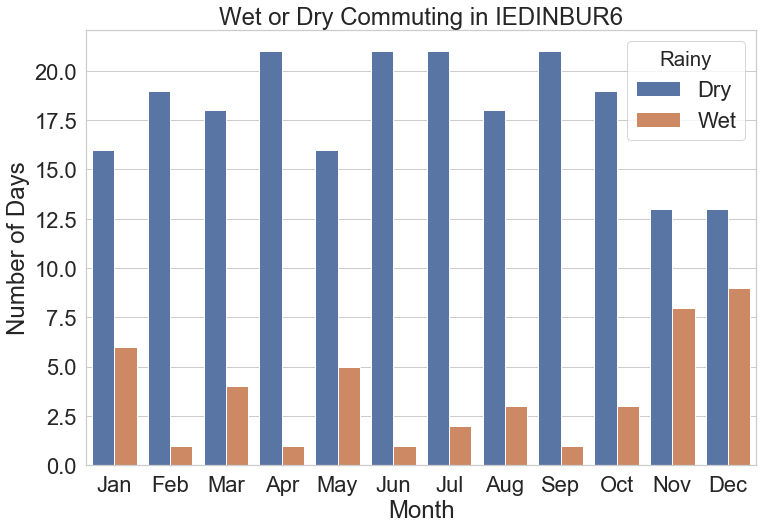

In [31]:
# Monthly plot of rainy days

plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)
sns.barplot(x="month_name", y="Days", hue="Rainy", data=monthly.sort_values(['month', 'Rainy']))
plt.xlabel("Month")
plt.ylabel("Number of Days")
plt.title("Wet or Dry Commuting in {}".format(station))

In [33]:
def analyse_station(data_raw, station):
    """
    Function to analyse weather data for a period from one weather station.
    
    Args:
        data_raw (pd.DataFrame): Pandas Dataframe made from CSV downloaded from wunderground.com
        station (String): Name of station being analysed (for comments)
    
    Returns:
        dict: Dictionary with analysis in keys:
            data: Processed and cleansed data
            monthly: Monthly aggregated statistics on rainfall etc.
            wet_cycling: Data on working days and whether you get wet or not commuting
            rainy_days: Daily total rainfall for each day in dataset.
    """
    # Give the variables some friendlier names and convert types as necessary.
    data_raw['temp'] = data_raw['TemperatureC'].astype(float)
    data_raw['rain'] = data_raw['HourlyPrecipMM'].astype(float)
    data_raw['total_rain'] = data_raw['dailyrainMM'].astype(float)
    data_raw['date'] = data_raw['DateUTC'].apply(parser.parse)
    data_raw['humidity'] = data_raw['Humidity'].astype(float)
    data_raw['wind_direction'] = data_raw['WindDirectionDegrees']
    data_raw['wind'] = data_raw['WindSpeedKMH']
    
    # Extract out only the data we need.
    data = data_raw.loc[:, ['date', 'station', 'temp', 'rain', 'total_rain', 'humidity', 'wind']]
    data = data[(data['date'] >= datetime(2015,1,1)) & (data['date'] <= datetime(2015,12,31))]
    
    # There's an issue with some stations that record rainfall ~-2500 where data is missing.
    if (data['rain'] < -500).sum() > 10:
        print("There's more than 10 messed up days for {}".format(station))
        
    # remove the bad samples
    data = data[data['rain'] > -500]

    # Assign the "day" to every date entry
    data['day'] = data['date'].apply(lambda x: x.date())

    # Get the time, day, and hour of each timestamp in the dataset
    data['time_of_day'] = data['date'].apply(lambda x: x.time())
    data['day_of_week'] = data['date'].apply(lambda x: x.weekday())    
    data['hour_of_day'] = data['time_of_day'].apply(lambda x: x.hour)
    # Mark the month for each entry so we can look at monthly patterns
    data['month'] = data['date'].apply(lambda x: x.month)

    # Is each time stamp on a working day (Mon-Fri)
    data['working_day'] = (data['day_of_week'] >= 0) & (data['day_of_week'] <= 4)

    # Classify into morning or evening times (assuming travel between 8.15-9am and 5.15-6pm)
    data['morning'] = (data['time_of_day'] >= time(8,15)) & (data['time_of_day'] <= time(9,0))
    data['evening'] = (data['time_of_day'] >= time(17,15)) & (data['time_of_day'] <= time(18,0))

    # If there's any rain at all, mark that!
    data['raining'] = data['rain'] > 0.0

    # You get wet cycling if its a working day, and its raining at the travel times!
    data['get_wet_cycling'] = (data['working_day']) & ((data['morning'] & data['rain']) |
                                                       (data['evening'] & data['rain']))
    # Looking at the working days only:
    wet_cycling = data[data['working_day'] == True].groupby('day')['get_wet_cycling'].any()
    wet_cycling = pd.DataFrame(wet_cycling).reset_index()
    
    # Group by month for display
    wet_cycling['month'] = wet_cycling['day'].apply(lambda x: x.month)
    monthly = wet_cycling.groupby('month')['get_wet_cycling'].value_counts().rename('Days').reset_index()
    monthly.rename(columns={"get_wet_cycling":"Rainy"}, inplace=True)
    monthly.replace({"Rainy": {True: "Wet", False:"Dry"}}, inplace=True)    
    monthly['month_name'] = monthly['month'].apply(lambda x: calendar.month_abbr[x])
    
    # Get aggregate stats for each day in the dataset.
    rainy_days = data.groupby(['day']).agg({
            "rain": {"rain": lambda x: (x > 0.0).any(),
                     "rain_amount": "sum"},
            "total_rain": {"total_rain": "max"},
            "get_wet_cycling": {"get_wet_cycling": "any"}
            })    
    rainy_days.reset_index(drop=False, inplace=True)
    rainy_days.rename(columns={"":"date"}, inplace=True)
    rainy_days.columns = rainy_days.columns.droplevel(level=0)
    rainy_days['rain'] = rainy_days['rain'].astype(bool)            
    
    # Also get the number of hours per day where its raining, and add this to the rainy_days dataset.
    temp = data.groupby(["day", "hour_of_day"])['raining'].any()
    temp = temp.groupby(level=[0]).sum().reset_index()
    temp.rename(columns={'raining': 'hours_raining'}, inplace=True)
    #temp['day'] = temp['day'].apply(lambda x: x.to_datetime().date())
    rainy_days = rainy_days.merge(temp, left_on='date', right_on='day', how='left')
    rainy_days.drop('day', axis=1, inplace=True)

    return {"data":data, 'monthly':monthly, "wet_cycling":wet_cycling, 'rainy_days': rainy_days}

In [34]:
# Load up each of the stations into memory.
stations = [
 ("IAMSTERD55", "Amsterdam"),
 ("IBCNORTH17", "Vancouver"),
 ("IBELFAST4", "Belfast"),
 ("IBERLINB54", "Berlin"),
 ("ICOGALWA4", "Galway"),
 ("ICOMUNID56", "Madrid"),
 ("IDUBLIND35", "Dublin"),
 ("ILAZIORO71", "Rome"),
 ("ILEDEFRA6", "Paris"),
 ("ILONDONL28", "London"),
 ("IMUNSTER11", "Cork"),
 ("INEWSOUT455", "Sydney"),
 ("ISOPAULO61", "Sao Paulo"),
 ("IWESTERN99", "Cape Town"),
 ("KCASANFR148", "San Francisco"),
 ("KNYBROOK40", "New York"),
 ("IRENFREW4", "Glasgow"),
 ("IENGLAND64", "Liverpool"),
 ('IEDINBUR6', 'Edinburgh')
]
data = []
for station in stations:
   weather = {}
   weather['data'] = pd.read_csv("{}_weather.csv".format(station[0]))
   weather['station'] = station[0]
   weather['name'] = station[1]
   data.append(weather)
    

for ii in range(len(data)):
    data[ii]['result'] = analyse_station(data[ii]['data'], data[ii]['station'])
 

# Now extract the number of wet days, the number of wet cycling days, and the number of wet commutes for a single chart.

output = []
for ii in range(len(data)):
    temp = {
            "total_wet_days": data[ii]['result']['rainy_days']['rain'].sum(),
            "wet_commutes": data[ii]['result']['wet_cycling']['get_wet_cycling'].sum(),
            "commutes": len(data[ii]['result']['wet_cycling']),
            "city": data[ii]['name']
        }
    temp['percent_wet_commute'] = (temp['wet_commutes'] *1.0 / temp['commutes'])*100
    output.append(temp)
output = pd.DataFrame(output)

There's more than 10 messed up days for IAMSTERD55


C:\Users\ramzi\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


There's more than 10 messed up days for IBERLINB54
There's more than 10 messed up days for KCASANFR148
There's more than 10 messed up days for IRENFREW4


## Using seaborn 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

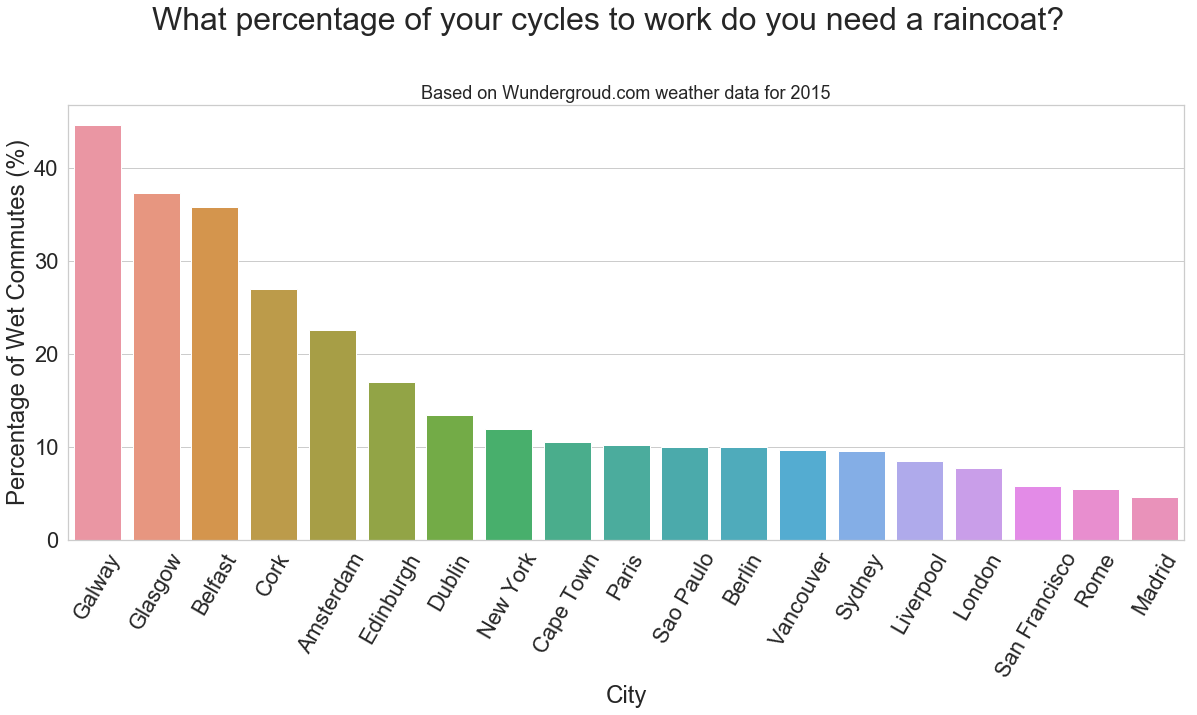

In [35]:
# Generate plot of percentage of wet commutes
plt.figure(figsize=(20,8))
sns.set_style("whitegrid")    # Set style for seaborn output
sns.set_context("notebook", font_scale=2)
sns.barplot(x="city", y="percent_wet_commute", data=output.sort_values('percent_wet_commute', ascending=False))
plt.xlabel("City")
plt.ylabel("Percentage of Wet Commutes (%)")
plt.suptitle("What percentage of your cycles to work do you need a raincoat?", y=1.05, fontsize=32)
plt.title("Based on Wundergroud.com weather data for 2015", fontsize=18)
plt.xticks(rotation=60)